In [1]:
import pandas as pd
import glob
import os


# Import data
filename = 'outputs/results/combined_enterprise_output.csv'

df = pd.read_csv(filename)


In [4]:
import datetime
from cve_matching import translate_vendor, fetch_CVEs, fetch_CVEs_with_split

# Filter vendors
excluded_vendors_file = "config/excluded_vendors.txt"
with open(excluded_vendors_file, 'r', encoding='utf-8') as file:
    excluded_vendors = {line.strip() for line in file if line.strip()}

size_before = df.shape[0]
print(excluded_vendors)
df = df[~df["Vendor"].isin(excluded_vendors)]
print("Dropped " + str(size_before - df.shape[0]) + " by vendor exclusion.\n" + str(df.shape[0]) + " entries left.")
print(df.columns)


# test_vendor = df["Vendor"][1]
# test_time = df["Engine Time"][1]

end_date = datetime.datetime.now()

# vendor_translated = translate_vendor(test_vendor)


# print(vendor_translated)
# cve_results = fetch_CVEs_with_split(vendor_translated, test_time, end_date=end_date)
#cve_results = fetch_CVEs(vendor_translated, test_time, end_date=end_date)

# print(test_time)
# print(cve_results)

vendor = 'Fortinet, Inc.'#NetScreen Technologies, Inc.'#SonicWALL, Inc.'Fortinet, Inc.'
max_engine_time = df[df["Vendor"] == vendor]["Engine Time"].max()
latest_reboot_date = max(df["Reboot Date"], key=lambda x: datetime.datetime.strptime(x, "%m_%d_%Y_%H_%M_%S"))
latest_reboot_datetime = datetime.datetime.strptime(latest_reboot_date, "%m_%d_%Y_%H_%M_%S")
#print(latest_reboot_date)
cves = fetch_CVEs_with_split(translate_vendor(vendor), max_engine_time, end_date=latest_reboot_datetime)
#print(cves)
print("Largest Engine Time for", vendor, ":", max_engine_time)
print("Number of CVEs found:", len(cves))
#cves = fetch_CVEs(vend)


{'Juniper Networks, Inc.', 'HUAWEI Technology Co.,Ltd', 'ciscoSystems', 'net-snmp'}
Dropped 0 by vendor exclusion.
7599 entries left.
Index(['IP', 'Enterprise Code', 'MAC', 'Engine Time', 'Engine Boots', 'Vendor',
       'Scan Date', 'Reboot Date'],
      dtype='object')
Largest Engine Time for Fortinet, Inc. : 53128722.0
Number of CVEs found: 195


/tmp/ipykernel_284395/2886250726.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Reboot_Datetime'] = pd.to_datetime(df_filtered['Reboot Date'], format='%m_%d_%Y_%H_%M_%S')


2023-09-27 19:42:41


(0.0, 274.0)

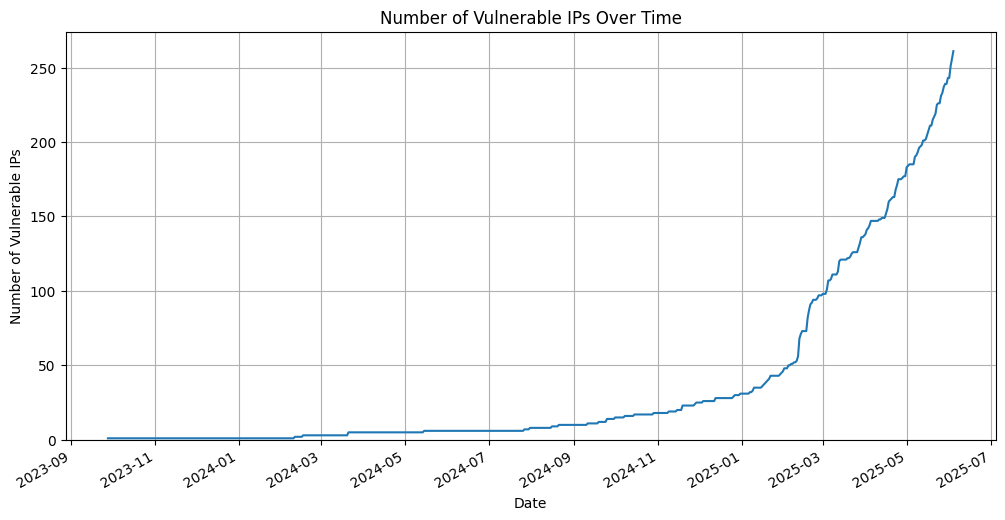

In [7]:
import matplotlib.pyplot as plt

# Convert reboot dates to datetime
# Filter dataframe for specified vendor
df_filtered = df[df['Vendor'] == vendor]
df_filtered['Reboot_Datetime'] = pd.to_datetime(df_filtered['Reboot Date'], format='%m_%d_%Y_%H_%M_%S')
df_filtered = df_filtered[df_filtered['Reboot_Datetime'].dt.year >= 1998]

# Create time series of vulnerability counts
print(df_filtered['Reboot_Datetime'].min())
time_range = pd.date_range(start=df_filtered['Reboot_Datetime'].min(), end=df_filtered['Reboot_Datetime'].max(), freq='D')
vulnerable_counts = []

for time_point in time_range:
    # Count IPs with reboot time older than this date (vulnerable)
    vulnerable_ips = df_filtered[df_filtered['Reboot_Datetime'] <= time_point]['IP'].nunique()
    vulnerable_counts.append(vulnerable_ips)

# Create and plot the time series
vulnerability_ts = pd.Series(vulnerable_counts, index=time_range)
vulnerability_ts.plot(figsize=(12, 6))
plt.title('Number of Vulnerable IPs Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Vulnerable IPs')
plt.grid(True)
#print(cves[cves['CVE_ID'] == 'CVE-2024-55591'])
# Add CVE dates as vertical lines
i = 0

start_date = df_filtered['Reboot_Datetime'].min()
end_date = df_filtered['Reboot_Datetime'].max()

for _, cve in cves.iterrows():
    cve_id = cve['CVE_ID']
    published_str = cve['Published']
    cve_date = pd.to_datetime(published_str).normalize()
    # Only plot if severity is above 8 and EPSS_Score is above 5
    if cve['CVSS_Score'] > 7 and cve['EPSS_Score'] > 5:
        if cve_date >= start_date and cve_date <= end_date:
            plt.axvline(x=cve_date, color='r', linestyle='--', alpha=1)
            # Alternate between bottom and 10% height for text placement
            text_height = plt.ylim()[0] + (plt.ylim()[1] - plt.ylim()[0]) * (0.1 * (i % 3))
            plt.text(cve_date, text_height, f'CVSS:{cve["CVSS_Score"]:.1f} EPSS:{cve["EPSS_Score"]:.1f}', 
                     horizontalalignment='left')
            i += 1
plt.ylim(bottom=0)  # Force y-axis to start at 0
            
#print("Max EPSS Score:", cves["EPSS_Score"].max())

/tmp/ipykernel_284395/214919052.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top10['Scan Date'] = pd.to_datetime(df_top10['Scan Date'], format='%m_%d_%H_%M_%S')
/tmp/ipykernel_284395/214919052.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top10['Reboot Date'] = pd.to_datetime(df_top10['Reboot Date'], format='%m_%d_%Y_%H_%M_%S')
/tmp/ipykernel_284395/214919052.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

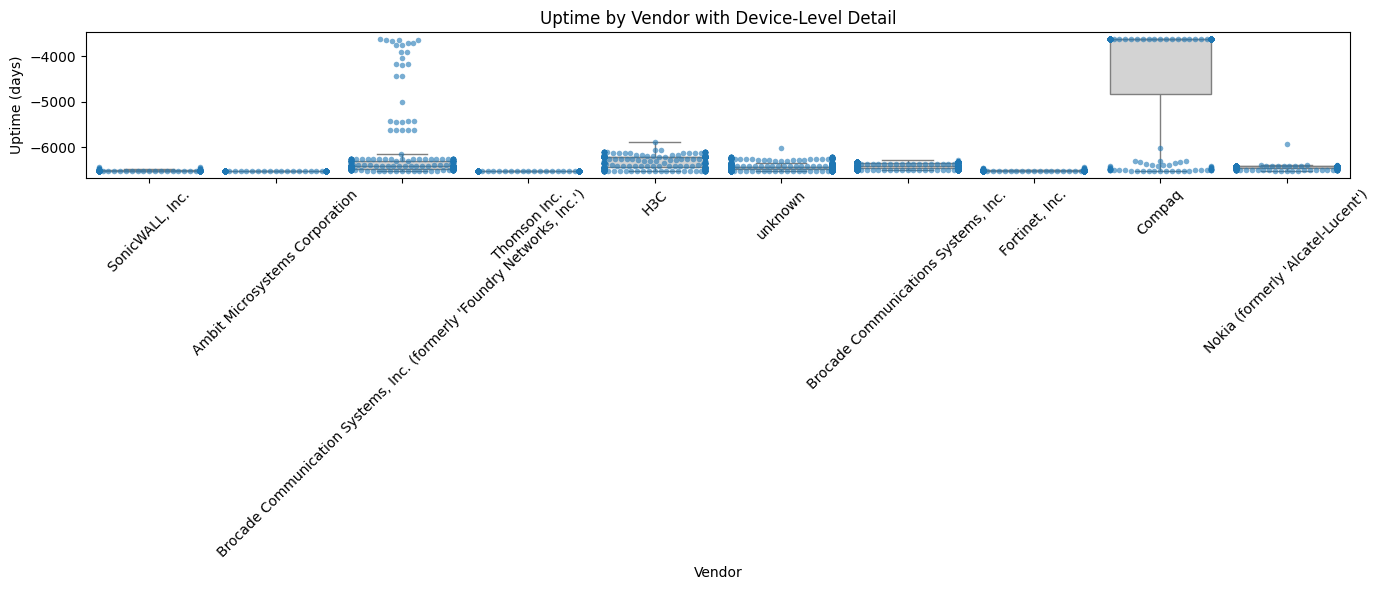

Empty DataFrame
Columns: [CVE_ID, Description, Published, CVSS_Score, Severity, CVSS_Version, EPSS_Score]
Index: []


In [27]:
import seaborn as sns
# Get top 10 vendors by count
top_10_vendors = df['Vendor'].value_counts().head(10).index
df_top10 = df[df['Vendor'].isin(top_10_vendors)]

df_top10['Scan Date'] = pd.to_datetime(df_top10['Scan Date'], format='%m_%d_%H_%M_%S')

df_top10['Reboot Date'] = pd.to_datetime(df_top10['Reboot Date'], format='%m_%d_%Y_%H_%M_%S')
df_top10['Uptime_Days'] = (df_top10['Scan Date'] - df_top10['Reboot Date']).dt.days / 7
# Convert Reboot Date to datetime for better handling
plt.figure(figsize=(14, 6))
sns.boxplot(x='Vendor', y='Uptime_Days', data=df_top10, color='lightgray', showfliers=False)
sns.swarmplot(x='Vendor', y='Uptime_Days', data=df_top10, size=4, alpha=0.6)
plt.xticks(rotation=45)
plt.title('Uptime by Vendor with Device-Level Detail')
plt.ylabel('Uptime (days)')
plt.xlabel('Vendor')
plt.tight_layout()
plt.show()
# Calculate uptime in weeks

print(cves.head(0))